In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=False)
from wordcloud import WordCloud
from geopy.geocoders import Nominatim
from folium.plugins import HeatMap
import folium
from tqdm import tqdm
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.colors as mcolors
from sklearn.manifold import TSNE
from gensim.models import word2vec
import nltk
import warnings
warnings.filterwarnings('ignore')

> **Breakdown of this notebook: Loading the dataset: Load the data and import the libraries. Data Cleaning:
> 
> 1.Cleaning column values.
> 2.Extracting digits for certain columns like Reviews, cost.
> 3.Dropping duplicates values.
> 4.Data Visualization: Using plots to find relations between the features.**

In [4]:
zomato=pd.read_csv('zomato_outlet_final.csv', delimiter=',')
zomato.head()

link  \
0  https://www.zomato.com/pune/mix@36-the-westin-...   
1  https://www.zomato.com/pune/kangan-the-westin-...   
2  https://www.zomato.com/pune/coriander-kitchen-...   
3  https://www.zomato.com/pune/the-market-the-wes...   
4  https://www.zomato.com/pune/vandaag-vivanta-pu...   

                                           rest_name          rest_type  \
0  Mix@36 - The Westin\r\r\n                     ...             Lounge   
1  Kangan - The Westin\r\r\n                     ...        Fine Dining   
2  Coriander Kitchen - Conrad Pune\r\r\n         ...        Fine Dining   
3  The Market - The Westin\r\r\n                 ...        Fine Dining   
4  Vandaag - Vivanta Pune\r\r\n                  ...  Pub,Casual Dining   

                             loc  dine_rating   dine_reviews  delivery_rating  \
0            The Westin, Mundhwa          4.2  (707 Reviews)              NaN   
1            The Westin, Mundhwa          4.1  (344 Reviews)              NaN   
2  Conrad Pune, Bund Garden Road          4.5  (541 Reviews)              NaN   
3            The Westin, Mundhwa          4.0   (55 Reviews)              NaN   
4        Vivanta Pune, Hinjewadi          3.9  (113 Reviews)              NaN   

  delivery_reviews                                      cuisine       cost  \
0              NaN  North Indian,Continental,Asian,Finger Food,  Rs. 4,300   
1              NaN                        North Indian,Mughlai,  Rs. 3,500   
2              NaN            Mediterranean,Asian,North Indian,  Rs. 3,200   
3              NaN                 Asian,European,North Indian,  Rs. 3,200   
4              NaN                     Finger Food,Continental,  Rs. 3,100   

                                               liked  
0                             Cocktails, Chaat, Beer  
1  Biryani, Veg Platter, Dal Makhani, Butter Chic...  
2  Pasta, Panipuri, Waffles, Pizza, Salad, Chaat,...  
3                    Vanilla Ice Cream, Chaat, Sushi  
4  Cocktails, Beer, Peri Peri Chicken, Fish, Veg ...

In [5]:
print("Dataset contains {} rows and {} columns".format(zomato.shape[0],zomato.shape[1]))

Dataset contains 5433 rows and 11 columns


In [6]:
zomato.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5433 entries, 0 to 5432
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   link              5433 non-null   object 
 1   rest_name         5433 non-null   object 
 2   rest_type         4336 non-null   object 
 3   loc               5433 non-null   object 
 4   dine_rating       4829 non-null   float64
 5   dine_reviews      4829 non-null   object 
 6   delivery_rating   2539 non-null   float64
 7   delivery_reviews  2539 non-null   object 
 8   cuisine           5433 non-null   object 
 9   cost              5433 non-null   object 
 10  liked             2603 non-null   object 
dtypes: float64(2), object(9)
memory usage: 467.0+ KB


# **Data Cleaning**

In [7]:
'Cleaning Data'
'Functions to remove special characters from name
def clean_data(cols, str_to_replace):
    
    for col in cols:
        zomato[col] = [str(x).replace(str_to_replace,"") for x in zomato[col]]
        
    return zomato

def extract_digit(cols):
    
    for col in cols:
        zomato[col] = zomato[col].str.extract(r'(\d+)', expand=True)
        
    return zomato
'Calling our Functions'
zomato = clean_data(['rest_name'], '\r\r\n')
zomato = clean_data(['rest_name'], '\r\n')
zomato = clean_data(['cost', 'dine_reviews', 'delivery_reviews'], ",")
zomato = extract_digit(['cost', 'dine_reviews', 'delivery_reviews'])

        

In [21]:
# Many location values have restaurant name as well.. So splitting them on the basis of delimiter and extracting string after the delimiter  
# Define a function to extract the desired part of the address
def extract_address(address):
    parts = address.split(',')
    return parts[1].strip() if len(parts) > 1 else address

# Apply the function to the 'location' column
zomato['locc'] = zomato['loc'].apply(extract_address)

# Display the resulting DataFrame

zomato

link  \
0     https://www.zomato.com/pune/mix@36-the-westin-...   
1     https://www.zomato.com/pune/kangan-the-westin-...   
2     https://www.zomato.com/pune/coriander-kitchen-...   
3     https://www.zomato.com/pune/the-market-the-wes...   
4     https://www.zomato.com/pune/vandaag-vivanta-pu...   
...                                                 ...   
4925  https://www.zomato.com/pune/murli-pure-veg-1-s...   
4926  https://www.zomato.com/pune/the-irani-cafe-res...   
4927  https://www.zomato.com/pune/hotel-shilpa-gavra...   
4928  https://www.zomato.com/pune/mh-12-pav-bhaji-ju...   
4929  https://www.zomato.com/pune/liyo-china-bt-kawa...   

                                              rest_name          rest_type  \
0     Mix@36 - The Westin                           ...             Lounge   
1     Kangan - The Westin                           ...        Fine Dining   
2     Coriander Kitchen - Conrad Pune               ...        Fine Dining   
3     The Market - The Westin                       ...        Fine Dining   
4     Vandaag - Vivanta Pune                        ...  Pub,Casual Dining   
...                                                 ...                ...   
4925  Murli Pure Veg                                ...      Casual Dining   
4926  The Irani Cafe Restaurant                     ...      Casual Dining   
4927  Hotel Shilpa Gavran                           ...      Casual Dining   
4928  MH 12 Pav Bhaji & Juice Center                ...        Quick Bites   
4929     Liyo China                                          Casual Dining   

                                loc  dine_rating  dine_reviews  \
0               The Westin, Mundhwa          4.2         707.0   
1               The Westin, Mundhwa          4.1         344.0   
2     Conrad Pune, Bund Garden Road          4.5         541.0   
3               The Westin, Mundhwa          4.0          55.0   
4           Vivanta Pune, Hinjewadi          3.9         113.0   
...                             ...          ...           ...   
4925                   Sinhgad Road          3.1          22.0   
4926                    Viman Nagar          2.9          80.0   
4927                         Pimpri          3.8          90.0   
4928                  Sadashiv Peth          3.1          24.0   
4929               B.T. Kawade Road          3.6          97.0   

      delivery_rating  delivery_reviews  \
0                 NaN               NaN   
1                 NaN               NaN   
2                 NaN               NaN   
3                 NaN               NaN   
4                 NaN               NaN   
...               ...               ...   
4925              3.5             253.0   
4926              NaN               NaN   
4927              NaN               NaN   
4928              3.1             439.0   
4929              3.8             365.0   

                                          cuisine    cost  \
0     North Indian,Continental,Asian,Finger Food,  4300.0   
1                           North Indian,Mughlai,  3500.0   
2               Mediterranean,Asian,North Indian,  3200.0   
3                    Asian,European,North Indian,  3200.0   
4                        Finger Food,Continental,  3100.0   
...                                           ...     ...   
4925           South Indian,Chinese,North Indian,   550.0   
4926                             Mughlai,Iranian,   800.0   
4927              Chinese,Fast Food,North Indian,   500.0   
4928     Beverages,Chinese,Street Food,Fast Food,   250.0   
4929                                Thai,Chinese,   500.0   

                                                  liked              locc  
0                                Cocktails, Chaat, Beer           Mundhwa  
1     Biryani, Veg Platter, Dal Makhani, Butter Chic...           Mundhwa  
2     Pasta, Panipuri, Waffles, Pizza, Salad, Chaat,...  Bund Garden Road  
3                       Vanilla Ice Cream, Chaat, Sushi   

In [23]:
#Checking for duplicates

zomato.drop_duplicates("link",keep='first',inplace=True)
zomato.reset_index(drop=True,inplace=True)
zomato.shape

(4930, 12)

In [24]:
print("Percentage null or na values in zomato")
((zomato.isnull() | zomato.isna()).sum() * 100 / zomato.index.size).round(2)

Percentage null or na values in zomato


link                 0.00
rest_name            0.00
rest_type           20.81
loc                  0.00
dine_rating         11.81
dine_reviews        11.81
delivery_rating     54.73
delivery_reviews    54.73
cuisine              0.00
cost                 0.00
liked               54.48
locc                 0.00
dtype: float64

In [25]:
#Checcking Data type of columns 
zomato.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4930 entries, 0 to 4929
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   link              4930 non-null   object 
 1   rest_name         4930 non-null   object 
 2   rest_type         3904 non-null   object 
 3   loc               4930 non-null   object 
 4   dine_rating       4348 non-null   float64
 5   dine_reviews      4348 non-null   float64
 6   delivery_rating   2232 non-null   float64
 7   delivery_reviews  2232 non-null   float64
 8   cuisine           4930 non-null   object 
 9   cost              4930 non-null   float64
 10  liked             2244 non-null   object 
 11  locc              4930 non-null   object 
dtypes: float64(5), object(7)
memory usage: 462.3+ KB


In [26]:
#Converting reviews and cost to integer

zomato.replace('NA', np.nan)
def convert_cols(cols):
    
    for col in cols:
        zomato[col] = zomato[col].astype(float)
        
    return zomato

zomato = convert_cols(['dine_reviews', 'delivery_reviews', 'cost'])


In [14]:
zomato

link  \
0     https://www.zomato.com/pune/mix@36-the-westin-...   
1     https://www.zomato.com/pune/kangan-the-westin-...   
2     https://www.zomato.com/pune/coriander-kitchen-...   
3     https://www.zomato.com/pune/the-market-the-wes...   
4     https://www.zomato.com/pune/vandaag-vivanta-pu...   
...                                                 ...   
4925  https://www.zomato.com/pune/murli-pure-veg-1-s...   
4926  https://www.zomato.com/pune/the-irani-cafe-res...   
4927  https://www.zomato.com/pune/hotel-shilpa-gavra...   
4928  https://www.zomato.com/pune/mh-12-pav-bhaji-ju...   
4929  https://www.zomato.com/pune/liyo-china-bt-kawa...   

                                              rest_name          rest_type  \
0     Mix@36 - The Westin                           ...             Lounge   
1     Kangan - The Westin                           ...        Fine Dining   
2     Coriander Kitchen - Conrad Pune               ...        Fine Dining   
3     The Market - The Westin                       ...        Fine Dining   
4     Vandaag - Vivanta Pune                        ...  Pub,Casual Dining   
...                                                 ...                ...   
4925  Murli Pure Veg                                ...      Casual Dining   
4926  The Irani Cafe Restaurant                     ...      Casual Dining   
4927  Hotel Shilpa Gavran                           ...      Casual Dining   
4928  MH 12 Pav Bhaji & Juice Center                ...        Quick Bites   
4929     Liyo China                                          Casual Dining   

                                loc  dine_rating  dine_reviews  \
0               The Westin, Mundhwa          4.2         707.0   
1               The Westin, Mundhwa          4.1         344.0   
2     Conrad Pune, Bund Garden Road          4.5         541.0   
3               The Westin, Mundhwa          4.0          55.0   
4           Vivanta Pune, Hinjewadi          3.9         113.0   
...                             ...          ...           ...   
4925                   Sinhgad Road          3.1          22.0   
4926                    Viman Nagar          2.9          80.0   
4927                         Pimpri          3.8          90.0   
4928                  Sadashiv Peth          3.1          24.0   
4929               B.T. Kawade Road          3.6          97.0   

      delivery_rating  delivery_reviews  \
0                 NaN               NaN   
1                 NaN               NaN   
2                 NaN               NaN   
3                 NaN               NaN   
4                 NaN               NaN   
...               ...               ...   
4925              3.5             253.0   
4926              NaN               NaN   
4927              NaN               NaN   
4928              3.1             439.0   
4929              3.8             365.0   

                                          cuisine    cost  \
0     North Indian,Continental,Asian,Finger Food,  4300.0   
1                           North Indian,Mughlai,  3500.0   
2               Mediterranean,Asian,North Indian,  3200.0   
3                    Asian,European,North Indian,  3200.0   
4                        Finger Food,Continental,  3100.0   
...                                           ...     ...   
4925           South Indian,Chinese,North Indian,   550.0   
4926                             Mughlai,Iranian,   800.0   
4927              Chinese,Fast Food,North Indian,   500.0   
4928     Beverages,Chinese,Street Food,Fast Food,   250.0   
4929                                Thai,Chinese,   500.0   

                                                  liked               locc  
0                                Cocktails, Chaat, Beer            Mundhwa  
1     Biryani, Veg Platter, Dal Makhani, Butter Chic...            Mundhwa  
2     Pasta, Panipuri, Waffles, Pizza, Salad, Chaat,...   Bund Garden Road  
3                       Vanilla Ice Cream, Chaat, Sush

# **Exploratory Data Analysis**

Which chain has maximum no of outlets in Pune?

Text(0.5, 0, 'Number of outlets')

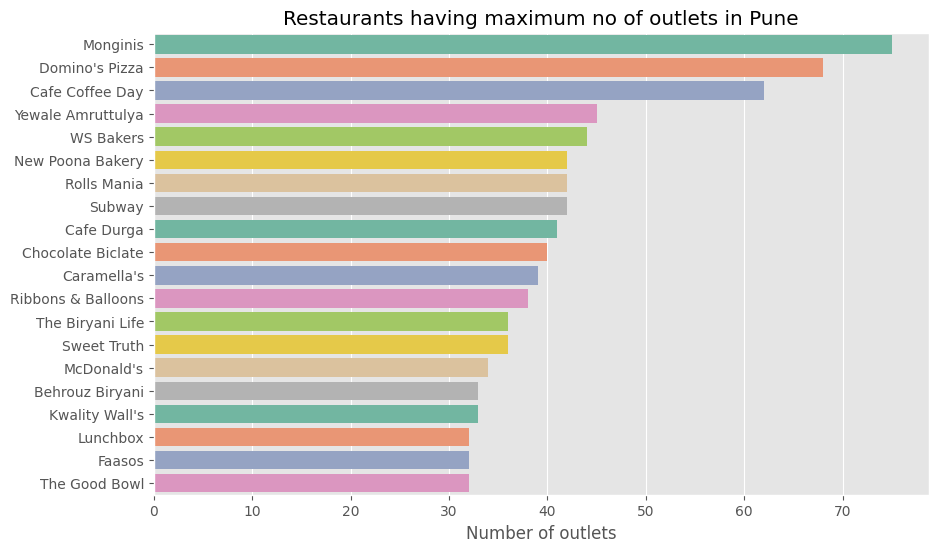

In [27]:
plt.figure(figsize=(10,6))
chains = zomato['rest_name'].value_counts()[:20]
sns.barplot(x=chains,y=chains.index.str.rstrip(),palette='Set2')
plt.title("Restaurants having maximum no of outlets in Pune")
plt.xlabel("Number of outlets")


# **Food Street in Pune**

Kothrud            254
Viman Nagar        243
Wakad              219
Baner              212
Hinjawadi          212
Hadapsar           198
Kharadi            187
Sinhgad Road       140
Pimple Saudagar    137
Aundh              120
Chinchwad          114
Koregaon Park      108
Kondhwa            103
Katraj              97
Pimpri              97
Karve Nagar         92
Camp Area           89
Magarpatta          83
Kalyani Nagar       82
Wagholi             81
Name: locc, dtype: int64


Text(0.5, 1.0, 'No of restaurants in Locality')

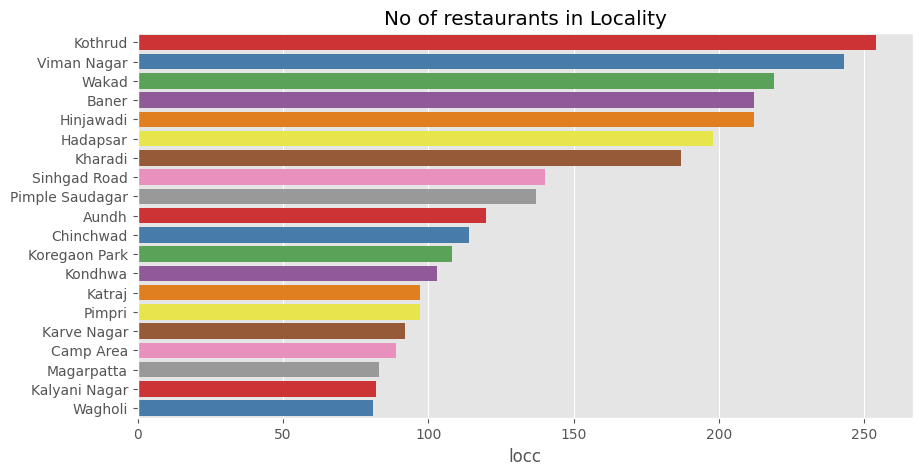

In [58]:
plt.figure(figsize=(10,5))
locations=zomato['locc'].value_counts()[:20]
print(locations)
g = sns.barplot(x=locations, y=locations.index, palette="Set1")
#g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
g
plt.title("No of restaurants in Locality")



# **Most preferred restaurant type in Pune**

Text(0.5, 0, 'Number of Restaurants')

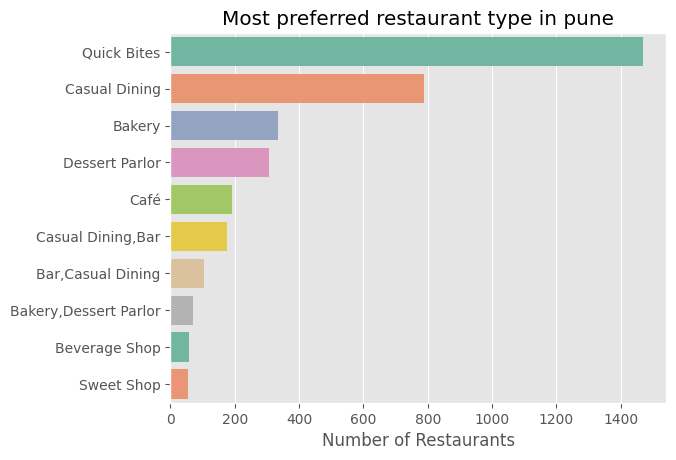

In [59]:
r_type =zomato['rest_type'].value_counts()[:10]
sns.barplot(x=r_type,y=r_type.index,palette='Set2')
plt.title("Most preferred restaurant type in pune")
plt.xlabel("Number of Restaurants")

* No doubt about this as Pune is known as the education hub of India,people having busy and modern life will prefer Quick Bites.
* We can observe tha Quick Bites type restaurants dominates.

['cuisine', 'liked']


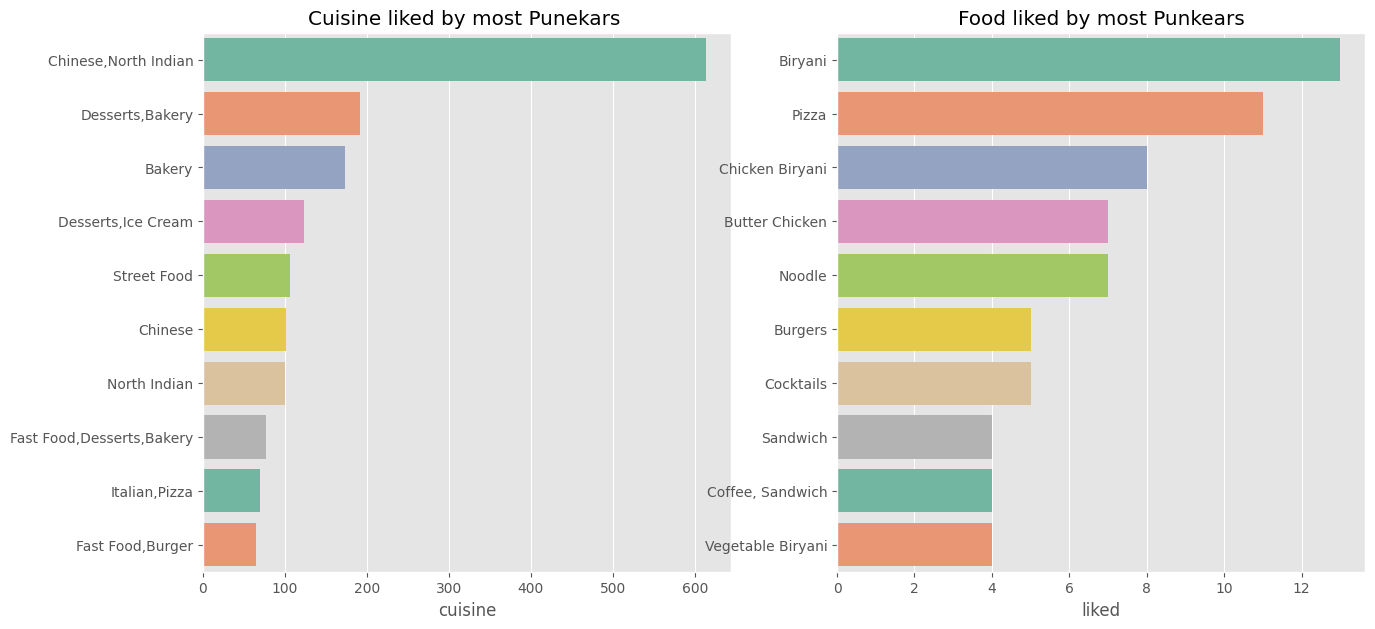

In [70]:
#Defining a fuction to plot graphs for top 10 attributes


def bar_plot_h(cols, title):
    print(cols)
    n=len(cols)
    f, axes = plt.subplots(1,2, figsize=(15,7))
    
    for col, ax, i in zip(cols, axes.flatten()[:n], range(0,n)):
        c=zomato[col].value_counts()[:10]
        sns.barplot(x=c, y=c.index.str.rstrip(","), ax = ax, palette='Set2').set_title(title[i])
        
        #For showing values in barplot
        
bar_plot_h(['cuisine', 'liked'], ["Cuisine liked by most Punekars ", "Food liked by most Punkears"])


# **Generating wordclouds for most liked dish**

There are 160709 words in the combination of all the review 


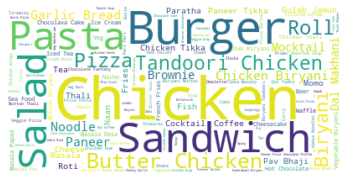

In [15]:
#Converting dish liked into 1 text time 

text = " ".join(str(dish) for dish in zomato.liked)
print("There are {} words in the combination of all the review ".format(len(text)))
stopwords = ['NaN']
wordcloud = WordCloud( stopwords = stopwords, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


# **Forming wordclouds for 5 restaurant type**

In [87]:
'Printing Restaurant types'
rest=zomato['rest_type'].value_counts().index
print(rest)

Index(['Quick Bites', 'Casual Dining', 'Bakery', 'Dessert Parlor', 'Café',
       'Casual Dining,Bar', 'Bar,Casual Dining', 'Bakery,Dessert Parlor',
       'Beverage Shop', 'Sweet Shop', 'Food Court', 'Lounge', 'Bar',
       'Fine Dining', 'Café,Dessert Parlor', 'Lounge,Casual Dining',
       'Bakery,Quick Bites', 'Sweet Shop,Quick Bites', 'Food Truck',
       'Dessert Parlor,Bakery', 'Café,Bakery', 'Dhaba',
       'Dessert Parlor,Quick Bites', 'Pub,Casual Dining', 'Bakery,Café',
       'Beverage Shop,Quick Bites', 'Café,Casual Dining',
       'Quick Bites,Food Court', 'Dessert Parlor,Beverage Shop',
       'Fine Dining,Bar', 'Irani Cafe', 'Quick Bites,Beverage Shop',
       'Beverage Shop,Dessert Parlor', 'Casual Dining,Café',
       'Quick Bites,Dessert Parlor', 'Kiosk', 'Pub', 'Club', 'Lounge,Bar',
       'Food Court,Quick Bites', 'Quick Bites,Sweet Shop', 'Mess',
       'Café,Quick Bites', 'Microbrewery', 'Bar,Pub', 'Casual Dining,Lounge',
       'Bhojanalya', 'Dessert Parlor,Café'

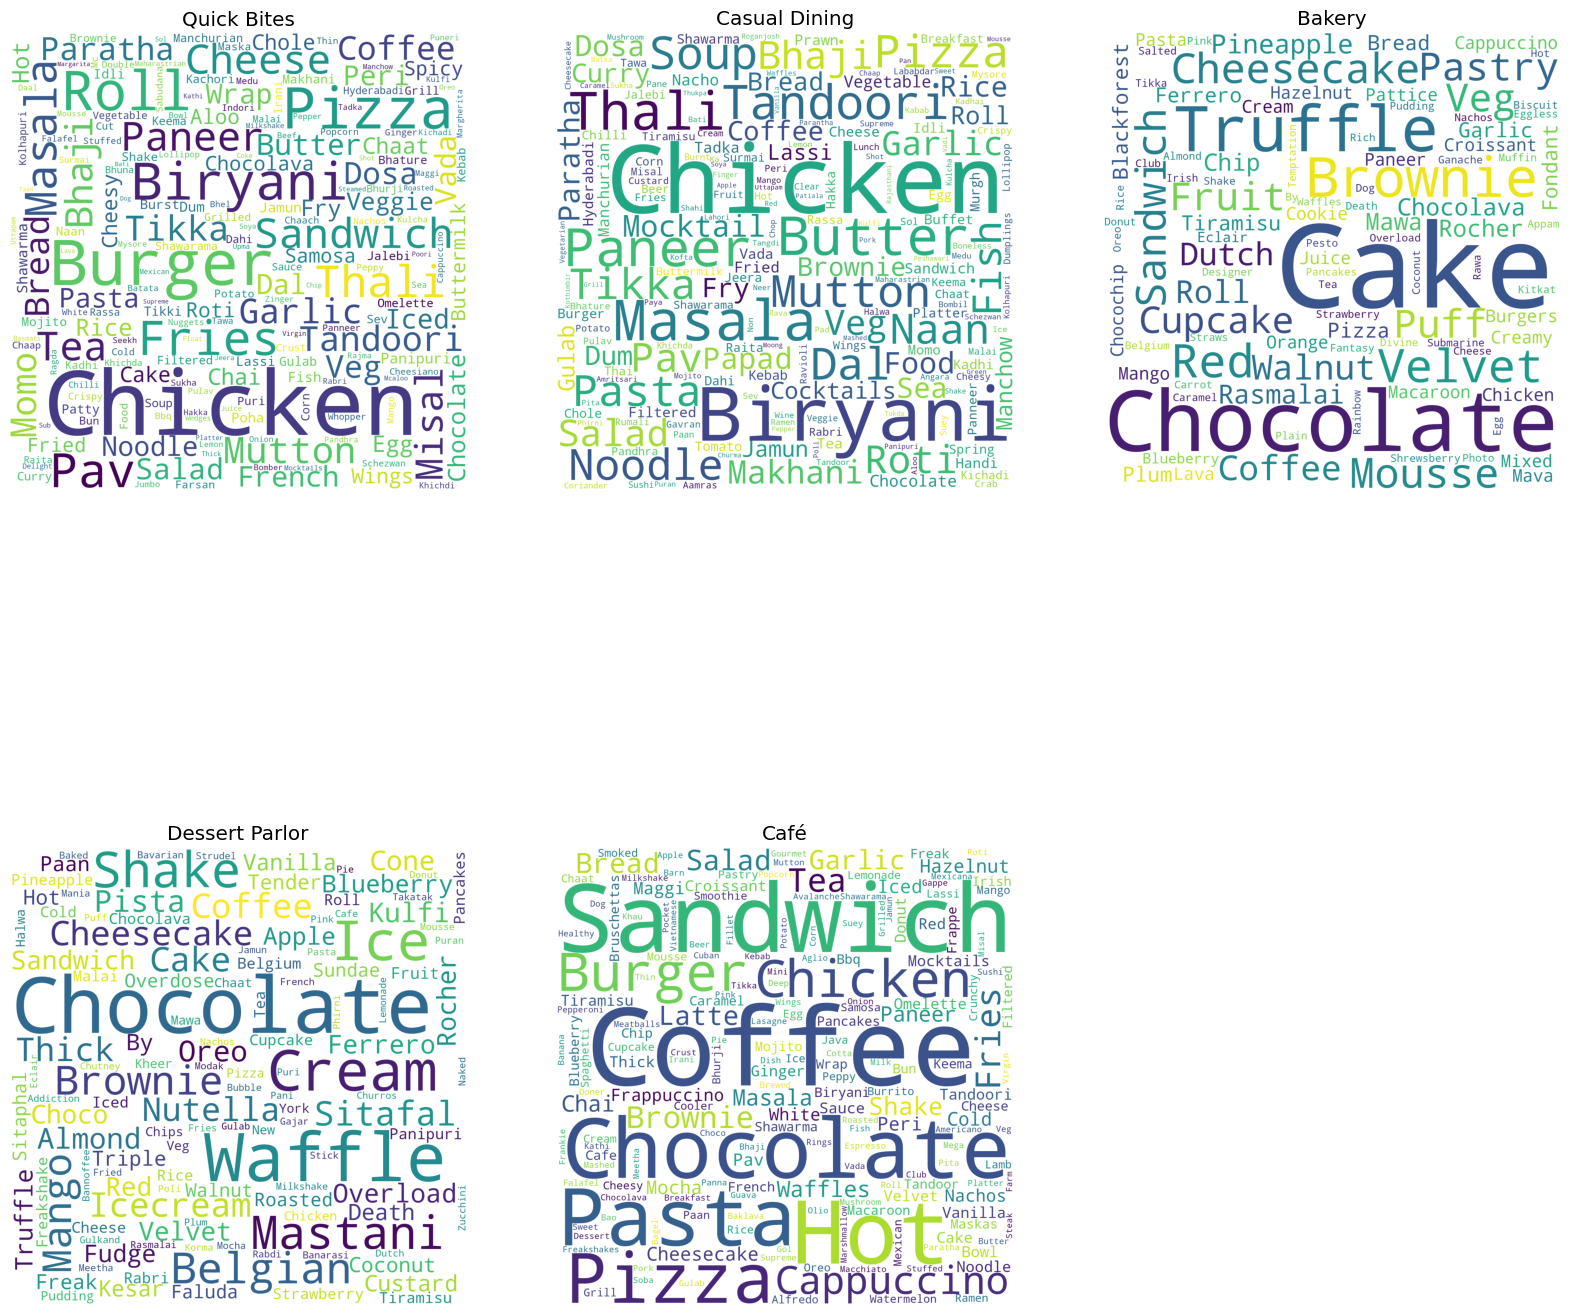

In [97]:
rest=zomato['rest_type'].value_counts()[:5].index

def produce_wordcloud(df,rest):
    stopwords = ['NaN']
    plt.figure(figsize=(20,30))
    for i,r in enumerate(rest):
        plt.subplot(3,3,i+1)
        corpus=df[df['rest_type']==r]['liked'].tolist()
        corpus=','.join(str(x) for x in corpus )
        wordcloud = WordCloud(stopwords = stopwords,max_font_size=None, background_color='white', collocations=False,
                             width=1500, height=1500).generate(corpus)
        plt.imshow(wordcloud)
        plt.title(r)
        plt.axis("off")
        
produce_wordcloud(zomato,rest)


# **Most voted restaurants in Pune**

['cost', 'dine_reviews']


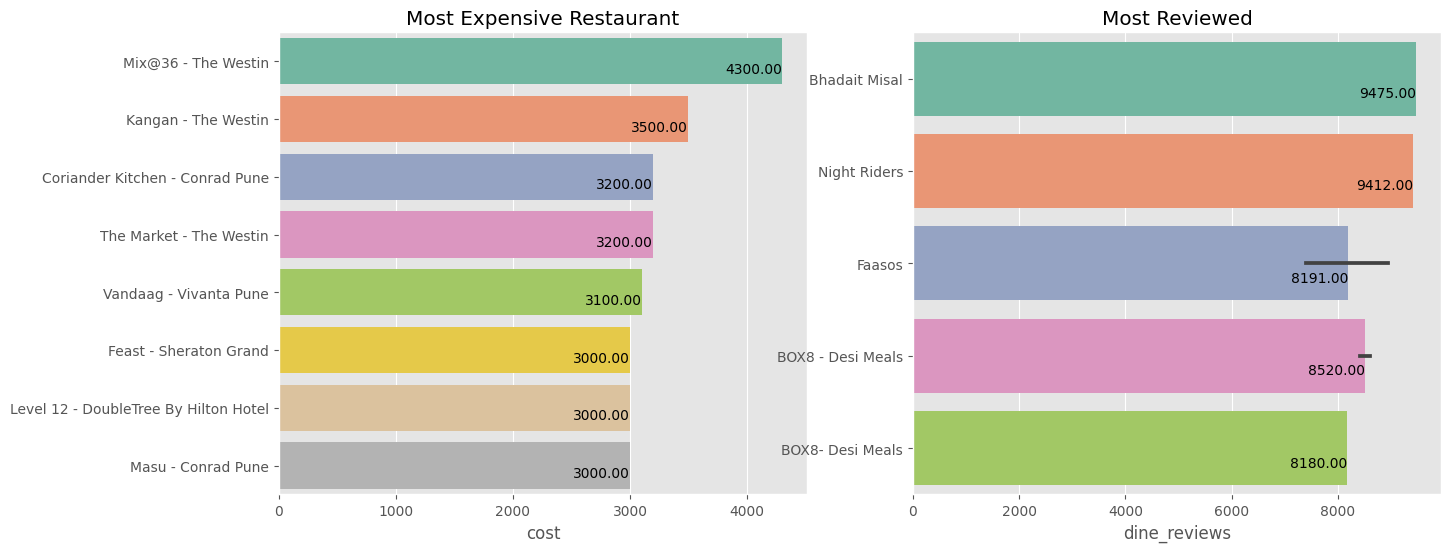

In [73]:
def bar_plot(cols, titles):
    print(cols)
    n=len(cols)
    f, axes = plt.subplots(1, 2, figsize=(15,6))
    for col, ax, i in zip(cols, axes.flatten()[:n], range(0,n)):
        c=zomato[['rest_name',col]].sort_values(by = col,ascending = False)[:8]
        g = sns.barplot(x = c[col], y=c['rest_name'].str.rstrip(),ax = ax, palette = 'Set2').set_title(titles[i])
        
        #For showing values in barplot 
        
        for p in ax.patches:
            width = p.get_width()
            ax.text(width -1.5  ,
                p.get_y()+p.get_height()/2. + 0.2,
                '{:1.2f}'.format(width),
                ha="right")
        ax.set_ylabel('') 
        
        
        
bar_plot( ['cost', 'dine_reviews'], ["Most Expensive Restaurant", "Most Reviewed"])

['wght_dine_rating', 'wght_delivery_rating']


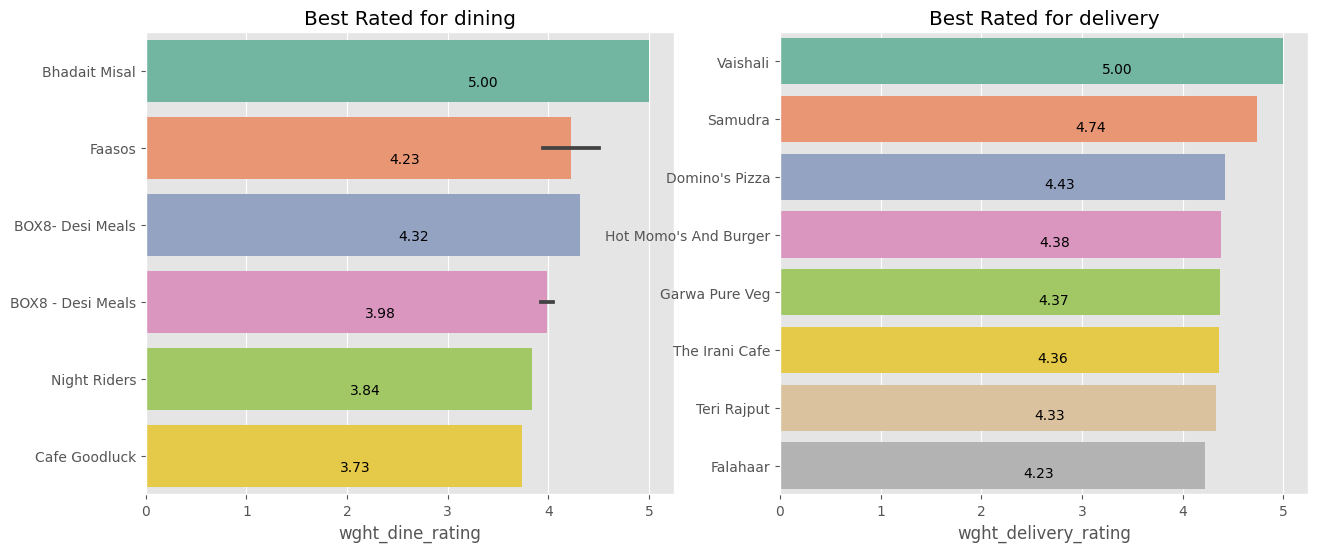

In [74]:
'''
Rating in itself is not a proper measure as no of reviews are not considered in it. So we will be calculating a weighted rating for both Dining and delivery
'''

' Calculate Weighted Rating '
zomato['wght_dine_rating'] = (zomato['dine_rating'] )* (zomato['dine_reviews']/zomato['dine_rating'].sum(axis = 0,skipna = True))
zomato['wght_delivery_rating'] =zomato['delivery_rating']*(zomato['delivery_reviews']/zomato['delivery_rating'].sum(axis=0,skipna=True) )

#Normalizing rating to bring them in the case of 0 to 5
zomato['wght_dine_rating']=5*(zomato['wght_dine_rating']-zomato['wght_dine_rating'].min(axis=0))/(zomato['wght_dine_rating'].max(axis=0) - zomato['wght_dine_rating'].min(axis=0))
zomato['wght_delivery_rating']=5*(zomato['wght_delivery_rating']-zomato['wght_delivery_rating'].min(axis=0))/(zomato['wght_delivery_rating'].max(axis=0) - zomato['wght_delivery_rating'].min(axis=0))
def bar_plot(cols, titles):
    print(cols)
    n=len(cols)
    f, axes = plt.subplots(1, 2, figsize=(15, 6))
    for col, ax, i  in zip(cols, axes.flatten()[:n], range(0,n)):
        c=zomato[['rest_name',col]].sort_values(by = col,ascending = False)[:8]
        g = sns.barplot(x = c[col], y =c['rest_name'].str.rstrip(),ax = ax, palette = 'Set2').set_title(titles[i])
        'For showing values in barplot'
        for p in ax.patches:
            width = p.get_width()
            ax.text(width -1.5  ,
                p.get_y()+p.get_height()/2. + 0.2,
                '{:1.2f}'.format(width),
                ha="right")
        ax.set_ylabel('')   

bar_plot( ['wght_dine_rating', 'wght_delivery_rating'], ['Best Rated for dining', 'Best Rated for delivery']) 

Text(0.5, 1.0, 'Cost distribution for all Restaurants')

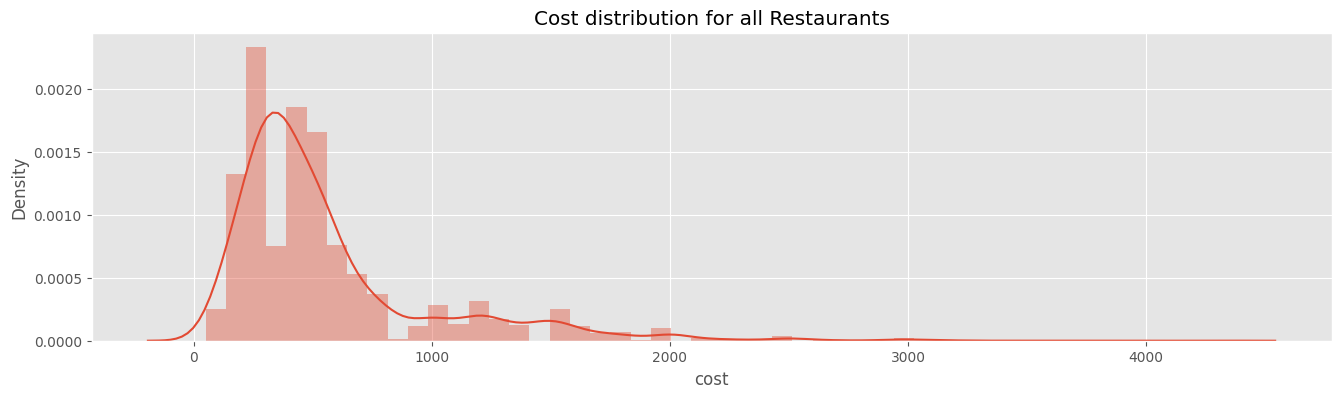

In [75]:
#Cost Distribution 

fig, ax = plt.subplots(figsize=[16,4])
sns.distplot(zomato['cost'],ax=ax)
ax.set_title('Cost distribution for all Restaurants')


# **Inferences -**
**More than 50% restaurants have rating between 3.5 and 4**

Text(0, 0.5, 'count')

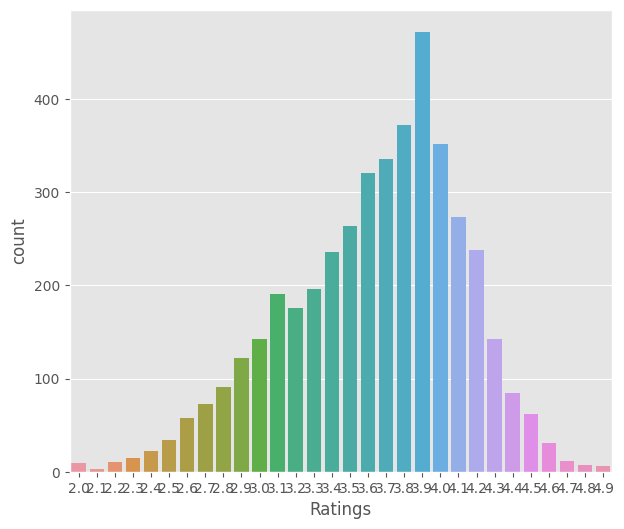

In [85]:
#Rating Distribution

plt.figure(figsize=(7,6))
rating=zomato['dine_rating'].value_counts()
sns.barplot(x=rating.index,y=rating)
plt.xlabel("Ratings")
plt.ylabel("count")
        

**Restaurants having rating more than 4.6 are very rare.**

# **Localities for Most Expensive 20 restaurants**

<AxesSubplot:xlabel='locc'>

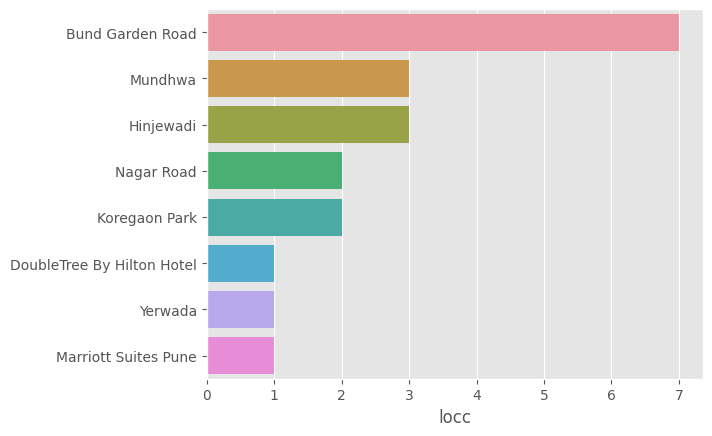

In [84]:
most_voted = zomato[['locc','cost']].sort_values(by = 'cost', ascending = False)[:20]
xy = most_voted['locc'].value_counts()
sns.barplot(x = xy, y = xy.index)

# **Best cheap Restaurants**

Criteria-

1.Cost<1000
2.Rating (dine or delivery)>4.3
3.No of reviews(dine or delivery)>4000

In [24]:
cheap_rest=zomato[['rest_name','cost', 'loc','rest_type','cuisine','delivery_rating', 'dine_rating', 'delivery_reviews', 'dine_reviews']]
cheap_rest=cheap_rest[(cheap_rest['cost'] <1000) & ( ( cheap_rest['dine_rating'] > 4.3 )| (cheap_rest['delivery_rating'] > 4.3)) &  ((cheap_rest['delivery_reviews'] > 4000) | (cheap_rest['dine_reviews'] >4000))]
cheap_rest.head(10)

rest_name   cost  \
763        Vaishali                                      500.0   
843   Momo's Corrner                                ...  200.0   
862   Domino's Pizza                                ...  400.0   
878   Domino's Pizza                                ...  400.0   
946   Cafe Goodluck                                      800.0   
1012  Cafe Samosa Corner                            ...  100.0   
1182  The Momo Panda                                ...  300.0   
1242  Bhadait Misal                                      150.0   
1302        Darshan                                      700.0   
1346    Rolls Mania                                      300.0   

                                 loc      rest_type  \
763                          FC Road  Casual Dining   
843                    Koregaon Park    Quick Bites   
862              Senapati Bapat Road    Quick Bites   
878                         Hadapsar    Quick Bites   
946                  Deccan Gymkhana    Quick Bites   
1012                         Kondhwa    Quick Bites   
1182                         Kothrud    Quick Bites   
1242                       Erandwane    Quick Bites   
1302                 Deccan Gymkhana  Casual Dining   
1346  Destination Centre, Magarpatta    Quick Bites   

                                                cuisine  delivery_rating  \
763          Beverages,Fast Food,Sandwich,South Indian,              4.6   
843                            Beverages,Tibetan,Momos,              3.9   
862                                      Italian,Pizza,              4.4   
878                                      Italian,Pizza,              4.4   
946   Desserts,Biryani,Maharashtrian,Mughlai,North I...              3.9   
1012                                       Street Food,              4.4   
1182                                             Momos,              4.5   
1242                                       Street Food,              NaN   
1302  Desserts,Street Food,Fast Food,Mexican,Chinese...              4.0   
1346                         Beverages,Fast Food,Rolls,              4.4   

      dine_rating  delivery_reviews  dine_reviews  
763           4.5            9562.0        5745.0  
843           4.6            4820.0         707.0  
862           3.6            8378.0         522.0  
878           3.0            7604.0         337.0  
946           4.4              30.0        7077.0  
1012          4.0            6526.0         264.0  
1182          4.3            7862.0         507.0  
1242          4.4               NaN        9475.0  
1302          4.5            3685.0        4672.0  
1346          4.1            8183.0         566.0

# **Highly Rated and reviewed Expensive restaurants**

In [25]:
exp_rest=zomato[['rest_name','cost','loc','rest_type','cuisine','delivery_rating','dine_rating','delivery_reviews','dine_reviews']]
exp_rest=exp_rest[(exp_rest['cost'] > 2500) & ( (exp_rest['dine_rating'] > 4.0)| (exp_rest['delivery_rating'] > 4.0))&   ((exp_rest['delivery_reviews'] > 400) | (exp_rest['dine_reviews'] > 400))].sort_values(by=['dine_reviews'], ascending = False)
exp_rest.head(20)


rest_name    cost  \
17  Oak Lounge - Marriott Suites Pune             ...  2700.0   
5   Baan Tao - Hyatt Pune                         ...  3000.0   
0   Mix@36 - The Westin                           ...  4300.0   
18  The Cafè - Hyatt Regency Pune                 ...  2600.0   
8   Feast - Sheraton Grand                        ...  3000.0   
2   Coriander Kitchen - Conrad Pune               ...  3200.0   

                                 loc    rest_type  \
17              Marriott Suites Pune       Lounge   
5             Hyatt Pune, Nagar Road  Fine Dining   
0                The Westin, Mundhwa       Lounge   
18     The Hyatt Regency, Nagar Road  Fine Dining   
8   Sheraton Grand, Bund Garden Road  Fine Dining   
2      Conrad Pune, Bund Garden Road  Fine Dining   

                                           cuisine  delivery_rating  \
17                                    Finger Food,              NaN   
5   Salad,Asian,Malaysian,Vietnamese,Thai,Chinese,              NaN   
0      North Indian,Continental,Asian,Finger Food,              NaN   
18                 Continental,Asian,North Indian,              NaN   
8                     European,Asian,North Indian,              NaN   
2                Mediterranean,Asian,North Indian,              NaN   

    dine_rating  delivery_reviews  dine_reviews  
17          4.2               NaN         845.0  
5           4.5               NaN         739.0  
0           4.2               NaN         707.0  
18          4.3               NaN         675.0  
8           4.5               NaN         577.0  
2           4.5               NaN         541.0

# **Interesting thing to note in Expensive restaurants is that none of them provide delivery.**

# **Cost Vs Rating**

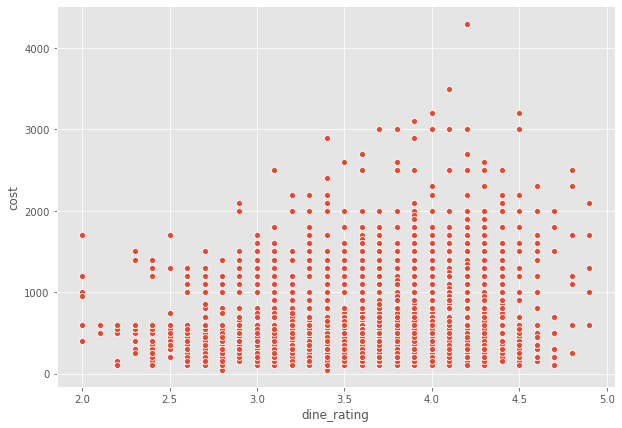

In [26]:
plt.figure(figsize=(10,7))
sns.scatterplot(x="dine_rating",y='cost',data=zomato)
plt.show()

# *** Distribution of cost ******

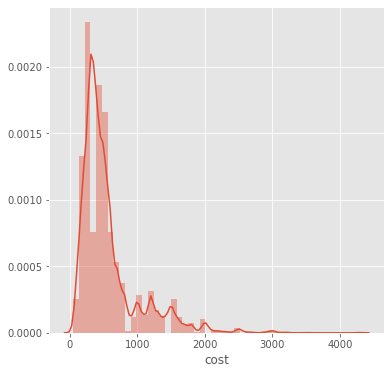

In [27]:
plt.figure(figsize=(6,6))
sns.distplot(zomato['cost'])
plt.show()

***** We can see that the distribution if left skewed.
* This means almost 90percent of restaurants serve food for budget less than 1000 INR.